In [28]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import karman
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import RandomSampler, SequentialSampler
import pickle as pk
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math
from sklearn.preprocessing import QuantileTransformer

torch.set_default_dtype(torch.float32)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
#here we set a few things, like the lag in minutes and the resolution of the data
lag_minutes=10000
resolution_minutes=100
features_to_exclude_thermo=["all__dates_datetime__", "tudelft_thermo__satellite__", "tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]", "all__year__[y]", "NRLMSISE00__thermospheric_density__[kg/m**3]"]
features_to_exclude_thermo+='celestrack__ap_average__,JB08__d_st_dt__[K],space_environment_technologies__f107_obs__,space_environment_technologies__f107_average__,space_environment_technologies__s107_obs__,space_environment_technologies__s107_average__,space_environment_technologies__m107_obs__,space_environment_technologies__m107_average__,space_environment_technologies__y107_obs__,space_environment_technologies__y107_average__'.split(',')

In [30]:
data_path={"omni_indices":'../data/omniweb_data/merged_omni_indices.csv', 
           "omni_solar_wind":'../data/omniweb_data/merged_omni_solar_wind.csv', 
           "omni_magnetic_field":'../data/omniweb_data/merged_omni_magnetic_field.csv',
           "soho":'../data/soho_data/soho_data.csv',
           "msise":'../data/nrlmsise00_data/nrlmsise00_time_series.csv'}

In [31]:
resolution_minutes=100
try:
    with open("ts_data_normalized.pk", "rb") as f:
        ts_data_normalized = pk.load(f)
except:
    ts_data_normalized = karman.util.normalize_time_series_data(resolution=resolution_minutes,
                                                                 data_path=data_path)
    #with open("ts_data_normalized.pk", "wb") as f:
    #    pk.dump(ts_data_normalized, f)

#let's pickle it:
#with open("ts_data_normalized.pk", "wb") as f:
#    pk.dump(ts_data_normalized, f)
#let's load from pickle to make things faster:
#with open("ts_data_normalized.pk", "rb") as f:
#    ts_data_normalized = pk.load(f)

In [32]:
import numpy as np
# We build the model entries:
n_grid=50
u, v = np.linspace(0, 1, n_grid), np.linspace(0, 1, n_grid)
longitude, latitude = np.sort(2 * np.pi * u), np.sort(np.arccos(2 * v - 1) - np.pi / 2)
lonlat_grid = np.stack([*np.meshgrid(longitude, latitude, indexing="ij")], axis=2).reshape(-1, 2) 
lonlat_grid[:,0]-=np.pi

In [33]:
#let's prepare the inputs to the model and run it:
longitudes=list(np.rad2deg(lonlat_grid[:,0],dtype=np.float32))
latitudes=list(np.rad2deg(lonlat_grid[:,1],dtype=np.float32))
n_samples=len(longitudes)
altitudes=[450000.]*n_samples#250km in meters
dates=['2022-05-08 00:59:47']*n_samples

In [34]:
model_path_ts='../models/ts_karman_model_tft_run_gpu_tft_w_omni_and_soho_wo_indices_and_proxies_w_10000_lag_100_resolution_valid_mape_14.936_params_1074865.torch'
ts_karman_model=karman.density_models.load_model(karman.density_models.num_static_features,
                                                model_path=model_path_ts,
                                                device="cpu",
                                                prediction_type="forecasting",
                                                configuration=karman.density_models._tft_configuration,)
ts_karman_model.eval()

number of parameters: 1074865


/home/ga00693/karman/notebooks/../karman/density_models.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ts_karman_model.load_state_dict(torch.load(model_path,map_locati

TemporalFusionTransformer(
  (static_transform): InputChannelEmbedding(
    (numeric_transform): NumericInputTransformation(
      (numeric_projection_layers): ModuleList(
        (0-7): 8 x Linear(in_features=1, out_features=64, bias=True)
      )
    )
    (categorical_transform): NullTransform()
  )
  (historical_ts_transform): InputChannelEmbedding(
    (numeric_transform): TimeDistributed(
      (module): NumericInputTransformation(
        (numeric_projection_layers): ModuleList(
          (0-24): 25 x Linear(in_features=1, out_features=64, bias=True)
        )
      )
    )
    (categorical_transform): NullTransform()
  )
  (future_ts_transform): InputChannelEmbedding(
    (numeric_transform): TimeDistributed(
      (module): NumericInputTransformation(
        (numeric_projection_layers): ModuleList(
          (0): Linear(in_features=1, out_features=64, bias=True)
        )
      )
    )
    (categorical_transform): NullTransform()
  )
  (static_selection): VariableSelectionNet

In [35]:
density_nn=karman.density_models.forecasting_model(dates=dates, 
                                                    altitudes=altitudes,
                                                    longitudes=longitudes,
                                                    latitudes=latitudes,
                                                    device=torch.device('cpu'),
                                                    ts_data_normalized=ts_data_normalized,
                                                    ts_karman_model=ts_karman_model,
                                                )

In [24]:
#let's extract the SW inputs to compute NRLMSISE-00:
sw_df=karman.util.find_sw_from_thermo(pd.to_datetime(dates),karman.density_models.df_sw)
ap=sw_df['celestrack__ap_average__'].values
f107=sw_df['space_environment_technologies__f107_obs__'].values
f107A=sw_df['space_environment_technologies__f107_average__'].values

In [25]:
from nrlmsise00 import msise_flat
d=pd.to_datetime(dates)
density_nrlmsise00=msise_flat(d.to_pydatetime(), altitudes, latitudes, longitudes, f107A, f107, ap)[:,5]*1e3

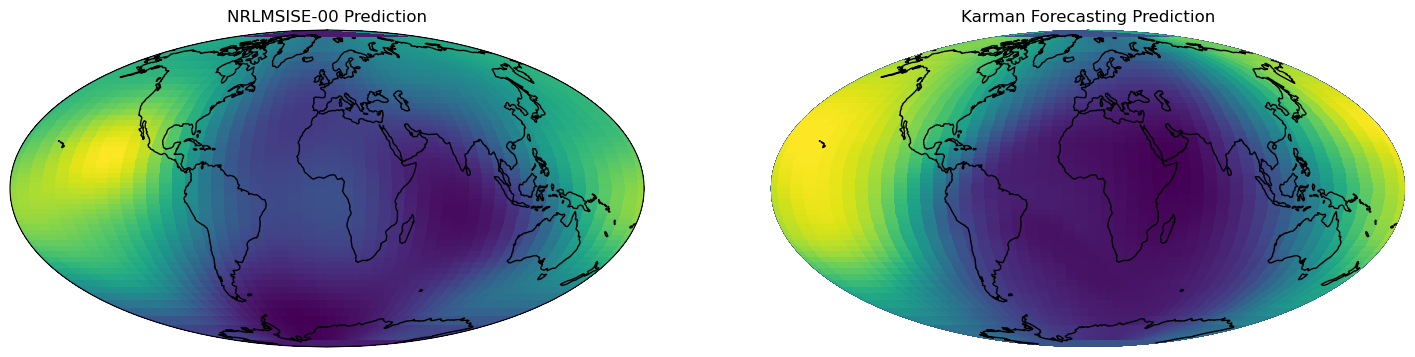

In [26]:
# we setup the longitude x latitude grid, and compute the relative error (in %)
lon_grid = np.rad2deg(lonlat_grid[:, 0].reshape((n_grid, n_grid)))
lat_grid = np.rad2deg(lonlat_grid[:, 1].reshape((n_grid, n_grid)))
#rel_err = ((density_nrlmsise00 - density_nn) / density_nn) * 100
# we print to scree the mean absolute percentage error on the globe map:
#print(
#    f"Average absolute relative percentage error on globe map: {abs(rel_err).mean()} %"
#)

# we now create a figure with a globe projection on top:
fig, ax = plt.subplots(
    figsize=(18, 12),
    nrows=1,
    ncols=2,
    subplot_kw={"projection": ccrs.Mollweide(central_longitude=0)},
)
# we flatten the axis and remove the last figure
ax = ax.ravel()
ax[-1].axis("off")

# we plot NRLMSISE-00 on the first figure:
ax[0].pcolormesh(
    lon_grid,
    lat_grid,
    density_nrlmsise00.reshape((n_grid, n_grid)),
    transform=ccrs.PlateCarree(),
    vmin=min(density_nrlmsise00),
    vmax=max(density_nrlmsise00),
)
ax[0].set_global()
ax[0].coastlines()
# ax[0].gridlines()
ax[0].set_title("NRLMSISE-00 Prediction")

# the NN prediction on the second:
im2 = ax[1].pcolormesh(
    lon_grid,
    lat_grid,
    density_nn.reshape((n_grid, n_grid)),
    transform=ccrs.PlateCarree(),
    vmin=min(density_nn),
    vmax=max(density_nn),
)
ax[1].set_global()
ax[1].coastlines()
# ax[1].gridlines()
ax[1].set_title("Karman Forecasting Prediction")
plt.show()
# we add a shared colorbar for the first two figures:
#cax1 = fig.add_axes([0.93, 0.6, 0.02, 0.2])  # [left, bottom, width, height]
#cbar1 = plt.colorbar(im2, orientation="vertical", fraction=0.035, cax=cax1)
#cbar1.set_label("Thermospheric Density [kg/m$^3$]")

# we finally plot the relative error in the second row
#im3 = ax[2].pcolormesh(
#    lon_grid,
#    lat_grid,
#    rel_err.reshape((n_grid, n_grid)),
#    transform=ccrs.PlateCarree(),
#    cmap="inferno",
#)
#ax[2].set_global()
#ax[2].coastlines()

# and we add the colorbar for that:
#cax2 = fig.add_axes([0.51, 0.1, 0.02, 0.3])  # [left, bottom, width, height]
#cbar1 = plt.colorbar(im3, orientation="vertical", fraction=0.035, cax=cax2)
#cbar1.set_label("Relative Error [%]")